3.2 Classification and regression with a two-layer perceptron




Generate some data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import trange
from abc import ABCMeta, abstractmethod

def generate_data(mA=(1, 0.3), mB=(0, 0.1), sigmaA=0.2, sigmaB=0.3):
    N=128
    np.random.seed(100)
    cov = np.eye(2)
    classA1 = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,N)
    classA2 = np.random.multivariate_normal([-1,0.3],sigmaA*sigmaA*cov,N)
    A = np.concatenate((classA1,classA2))
    B = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,N)
    labels = np.concatenate((np.ones(A.shape[0]), -np.ones(B.shape[0])))
    samples = np.concatenate((A, B))
    permute = np.random.permutation(A.shape[0] + B.shape[0])
    return samples[permute, :], labels[permute]

Def of NN

In [2]:
class Parameter(object):
    def __init__(self, data, requires_grad, skip_decay=False):
        self.data = data
        self.grad = None
        self.skip_decay = skip_decay
        self.requires_grad = requires_grad

    @property
    def T(self):
        return self.data.T

class SGD(object):
    def __init__(self, parameters, lr, decay=0):
        self.parameters = [p for p in parameters if p.requires_grad]   
        self.lr = lr
        self.decay_rate = 1.0 - decay

    def update(self):
        for p in self.parameters:
            if self.decay_rate < 1 and not p.skip_decay: p.data *= self.decay_rate
           # print("data",p.data,"grad",p.grad)
            p.data -= self.lr * p.grad


class MSE:
    def __init__(self):
        pass
    def gradient(self):
        return self.a - self.y
    
    def __call__(self, output, target, requires_acc=True):
        self.a = output
        self.y = np.reshape(target,(-1,1))
        loss = 0.5*np.multiply(self.a-self.y,self.a-self.y).mean()
        if requires_acc:
            acc = np.sum(np.sign(output)==self.y)/output.shape[0]
            return loss,acc
        return loss

class Layer():
    @abstractmethod
    def forward(self, *args):
        pass

    @abstractmethod
    def backward(self, *args):
        pass

class Tanh(Layer):
    def forward(self, x):
        ex = np.exp(x)
        esx = np.exp(-x)
        self.y = (ex - esx) / (ex + esx)
        return self.y

    def backward(self, eta):
        return np.einsum('...,...,...->...', 1 - self.y, 1 + self.y, eta, optimize=True)

class Linear(Layer):
    def __init__(self, shape, requires_grad=True, bias=True, **kwargs):
        '''
        shape = (in_size, out_size)
        '''
        W = np.random.randn(*shape) * (2 / shape[0]**0.5)
      #  print(W.shape)
        self.W = Parameter(W, requires_grad)
        self.b = Parameter(np.zeros(shape[-1]), requires_grad) if bias else None
        self.require_grad = requires_grad

    def forward(self, x):
        if self.require_grad: self.x = x
        out = np.dot(x, self.W.data)
        if self.b is not None: out = out + self.b.data
        return out

    def backward(self, eta):
       if self.require_grad:
            batch_size = eta.shape[0]
            self.W.grad = np.dot(self.x.T, eta) / batch_size
            if self.b is not None: self.b.grad = np.sum(eta, axis=0) / batch_size
       return np.dot(eta, self.W.T)
class Net(Layer):
    def __init__(self, layer_configures):
        self.layers = []
        self.parameters=[]
        for config in layer_configures:
            self.layers.append(self.createLayer(config))

    def createLayer(self, config):
        return self.getDefaultLayer(config)

    def getDefaultLayer(self, config):
        t = config['type']
        if t == 'linear':
            layer = Linear(**config)
            self.parameters.append(layer.W)
            if layer.b is not None: self.parameters.append(layer.b)
        elif t == 'tanh':
            layer = Tanh()
        return layer

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, eta):
        for layer in self.layers[::-1]:
            eta = layer.backward(eta)
        return eta
    
    def train(self,X,Y,optimizer,batch_size=16,epochs=500,loss=MSE()):
        n = len(Y)
        for epoch in trange(epochs):
            i = 0 
            while i<= n-batch_size:
                x,y=X[i:i+batch_size,],Y[i:i+batch_size,]
                i+=batch_size
                output = self.forward(x)
                batch_loss, batch_acc = loss(output,y)
                eta = loss.gradient()
                self.backward(eta)
                optimizer.update()
                if epoch % 100==0:
                    print("epoch: %d, batch: %5d, batch_acc:    %.2f,batch loss: %.2f" % \
                    (epoch, i/batch_size,batch_acc*100,batch_loss))

In [3]:
M=np.array([1,2,3]).reshape(1,3)
D=np.array([1,2,3]).reshape(1,3)
print(M==D)

[[ True  True  True]]


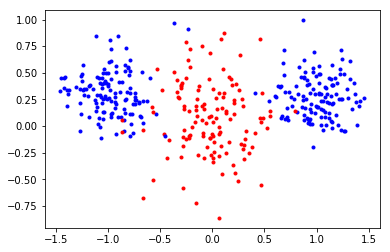

  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    50.00,batch loss: 0.77
epoch: 0, batch:     2, batch_acc:    43.75,batch loss: 0.98
epoch: 0, batch:     3, batch_acc:    56.25,batch loss: 0.81
epoch: 0, batch:     4, batch_acc:    62.50,batch loss: 0.56
epoch: 0, batch:     5, batch_acc:    37.50,batch loss: 1.03
epoch: 0, batch:     6, batch_acc:    62.50,batch loss: 0.66
epoch: 0, batch:     7, batch_acc:    50.00,batch loss: 0.86
epoch: 0, batch:     8, batch_acc:    62.50,batch loss: 0.57
epoch: 0, batch:     9, batch_acc:    37.50,batch loss: 1.02
epoch: 0, batch:    10, batch_acc:    43.75,batch loss: 0.95
epoch: 0, batch:    11, batch_acc:    68.75,batch loss: 0.46
epoch: 0, batch:    12, batch_acc:    62.50,batch loss: 0.60
epoch: 0, batch:    13, batch_acc:    68.75,batch loss: 0.63
epoch: 0, batch:    14, batch_acc:    56.25,batch loss: 0.74
epoch: 0, batch:    15, batch_acc:    43.75,batch loss: 0.92
epoch: 0, batch:    16, batch_acc:    37.50,batch loss: 0.94
epoch: 0, batch:    17, 

 39%|███████████████████████████████████████████▌                                                                   | 196/500 [00:02<00:03, 91.09it/s]

epoch: 200, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 200, batch:     2, batch_acc:    12.50,batch loss: 1.74
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.24
epoch: 200, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     5, batch_acc:    18.75,batch loss: 1.61
epoch: 200, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     8, batch_acc:    25.00,batch loss: 1.49
epoch: 200, batch:     9, batch_acc:    37.50,batch loss: 1.24
epoch: 200, batch:    10, batch_acc:    50.00,batch loss: 0.99
epoch: 200, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    14, batch_acc:    25.00,batch loss: 1.49
epoch: 200, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    16, batch_acc:    31.25,batch los

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                      | 398/500 [00:04<00:00, 102.54it/s]

epoch: 400, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 400, batch:     2, batch_acc:    12.50,batch loss: 1.74
epoch: 400, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     5, batch_acc:    18.75,batch loss: 1.62
epoch: 400, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     8, batch_acc:    25.00,batch loss: 1.49
epoch: 400, batch:     9, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:    10, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    14, batch_acc:    25.00,batch loss: 1.49
epoch: 400, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    16, batch_acc:    31.25,batch los

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 84.24it/s]


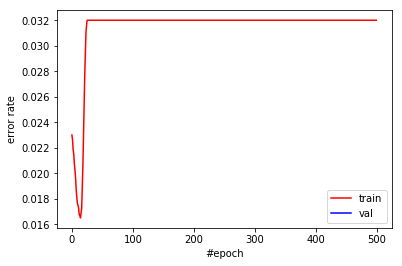

In [4]:

X,Y = generate_data()
for i, it in enumerate(X):
    if Y[i] == -1:
        plt.plot(X[i][0], X[i][1], 'r.')
    else:
        plt.plot(X[i][0], X[i][1], 'b.')
plt.show()
layers =[
    {'type':'linear','shape':(2,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


1. Modify the number of hidden nodes and demonstrate the effect the size of the hidden layer has on the performance (both the mean squared error and the number/ratio of misclassifications). How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?


  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    37.50,batch loss: 1.12
epoch: 0, batch:     2, batch_acc:    12.50,batch loss: 1.43
epoch: 0, batch:     3, batch_acc:    25.00,batch loss: 1.35
epoch: 0, batch:     4, batch_acc:    25.00,batch loss: 1.40
epoch: 0, batch:     5, batch_acc:    6.25,batch loss: 1.51
epoch: 0, batch:     6, batch_acc:    31.25,batch loss: 1.26
epoch: 0, batch:     7, batch_acc:    43.75,batch loss: 0.99
epoch: 0, batch:     8, batch_acc:    18.75,batch loss: 1.46
epoch: 0, batch:     9, batch_acc:    31.25,batch loss: 1.26
epoch: 0, batch:    10, batch_acc:    50.00,batch loss: 0.84
epoch: 0, batch:    11, batch_acc:    18.75,batch loss: 1.49
epoch: 0, batch:    12, batch_acc:    25.00,batch loss: 1.41
epoch: 0, batch:    13, batch_acc:    25.00,batch loss: 1.27
epoch: 0, batch:    14, batch_acc:    25.00,batch loss: 1.42
epoch: 0, batch:    15, batch_acc:    25.00,batch loss: 1.22
epoch: 0, batch:    16, batch_acc:    18.75,batch loss: 1.45
epoch: 0, batch:    17, b

 38%|█████████████████████████████████████████▊                                                                    | 190/500 [00:01<00:03, 102.46it/s]

epoch: 200, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 200, batch:     2, batch_acc:    12.50,batch loss: 1.75
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 200, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     5, batch_acc:    18.75,batch loss: 1.62
epoch: 200, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     8, batch_acc:    25.00,batch loss: 1.50
epoch: 200, batch:     9, batch_acc:    37.50,batch loss: 1.25
epoch: 200, batch:    10, batch_acc:    50.00,batch loss: 1.00
epoch: 200, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    14, batch_acc:    25.00,batch loss: 1.50
epoch: 200, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    16, batch_acc:    31.25,batch los

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                      | 398/500 [00:03<00:00, 117.52it/s]

epoch: 400, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 400, batch:     2, batch_acc:    12.50,batch loss: 1.75
epoch: 400, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     5, batch_acc:    18.75,batch loss: 1.62
epoch: 400, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     8, batch_acc:    25.00,batch loss: 1.50
epoch: 400, batch:     9, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:    10, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    14, batch_acc:    25.00,batch loss: 1.50
epoch: 400, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    16, batch_acc:    31.25,batch los

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.69it/s]


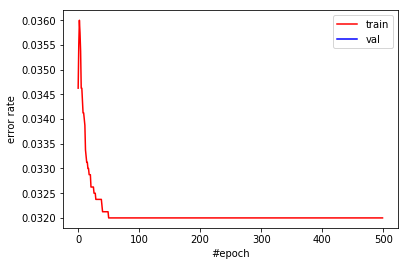

In [5]:
layers =[
    {'type':'linear','shape':(2,2)},
    {'type':'tanh'},
    {'type':'linear','shape':(2,2)},
    {'type':'tanh'},
    {'type':'linear','shape':(2,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    43.75,batch loss: 0.65
epoch: 0, batch:     2, batch_acc:    56.25,batch loss: 0.60
epoch: 0, batch:     3, batch_acc:    50.00,batch loss: 0.61
epoch: 0, batch:     4, batch_acc:    37.50,batch loss: 0.84
epoch: 0, batch:     5, batch_acc:    62.50,batch loss: 0.50
epoch: 0, batch:     6, batch_acc:    37.50,batch loss: 0.77
epoch: 0, batch:     7, batch_acc:    37.50,batch loss: 0.67
epoch: 0, batch:     8, batch_acc:    43.75,batch loss: 0.82
epoch: 0, batch:     9, batch_acc:    56.25,batch loss: 0.49
epoch: 0, batch:    10, batch_acc:    50.00,batch loss: 0.57
epoch: 0, batch:    11, batch_acc:    25.00,batch loss: 0.92
epoch: 0, batch:    12, batch_acc:    43.75,batch loss: 0.80
epoch: 0, batch:    13, batch_acc:    43.75,batch loss: 0.73
epoch: 0, batch:    14, batch_acc:    43.75,batch loss: 0.74
epoch: 0, batch:    15, batch_acc:    50.00,batch loss: 0.67
epoch: 0, batch:    16, batch_acc:    62.50,batch loss: 0.48
epoch: 0, batch:    17, 

 38%|██████████████████████████████████████████▍                                                                    | 191/500 [00:02<00:03, 91.77it/s]

epoch: 200, batch:     1, batch_acc:    43.75,batch loss: 1.08
epoch: 200, batch:     2, batch_acc:    12.50,batch loss: 1.67
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.19
epoch: 200, batch:     4, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:     5, batch_acc:    18.75,batch loss: 1.55
epoch: 200, batch:     6, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:     7, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:     8, batch_acc:    25.00,batch loss: 1.43
epoch: 200, batch:     9, batch_acc:    37.50,batch loss: 1.19
epoch: 200, batch:    10, batch_acc:    50.00,batch loss: 0.96
epoch: 200, batch:    11, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:    12, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:    13, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:    14, batch_acc:    25.00,batch loss: 1.43
epoch: 200, batch:    15, batch_acc:    31.25,batch loss: 1.31
epoch: 200, batch:    16, batch_acc:    31.25,batch los

 80%|████████████████████████████████████████████████████████████████████████████████████████▌                      | 399/500 [00:04<00:01, 98.47it/s]

epoch: 400, batch:     1, batch_acc:    43.75,batch loss: 1.11
epoch: 400, batch:     2, batch_acc:    12.50,batch loss: 1.72
epoch: 400, batch:     3, batch_acc:    37.50,batch loss: 1.23
epoch: 400, batch:     4, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:     5, batch_acc:    18.75,batch loss: 1.60
epoch: 400, batch:     6, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:     7, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:     8, batch_acc:    25.00,batch loss: 1.47
epoch: 400, batch:     9, batch_acc:    37.50,batch loss: 1.23
epoch: 400, batch:    10, batch_acc:    50.00,batch loss: 0.98
epoch: 400, batch:    11, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:    12, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:    13, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:    14, batch_acc:    25.00,batch loss: 1.47
epoch: 400, batch:    15, batch_acc:    31.25,batch loss: 1.35
epoch: 400, batch:    16, batch_acc:    31.25,batch los

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.73it/s]


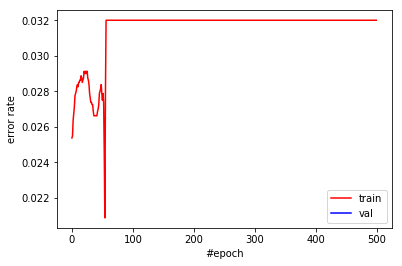

In [6]:
layers =[
    {'type':'linear','shape':(2,1)},
    {'type':'tanh'},
    {'type':'linear','shape':(1,1)},
    {'type':'tanh'},
    {'type':'linear','shape':(1,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    56.25,batch loss: 0.81
epoch: 0, batch:     2, batch_acc:    43.75,batch loss: 1.07
epoch: 0, batch:     3, batch_acc:    50.00,batch loss: 0.94
epoch: 0, batch:     4, batch_acc:    62.50,batch loss: 0.59
epoch: 0, batch:     5, batch_acc:    37.50,batch loss: 1.19
epoch: 0, batch:     6, batch_acc:    62.50,batch loss: 0.68
epoch: 0, batch:     7, batch_acc:    62.50,batch loss: 0.75
epoch: 0, batch:     8, batch_acc:    56.25,batch loss: 0.82
epoch: 0, batch:     9, batch_acc:    43.75,batch loss: 1.10
epoch: 0, batch:    10, batch_acc:    50.00,batch loss: 0.96
epoch: 0, batch:    11, batch_acc:    75.00,batch loss: 0.52
epoch: 0, batch:    12, batch_acc:    56.25,batch loss: 0.73
epoch: 0, batch:    13, batch_acc:    56.25,batch loss: 0.76
epoch: 0, batch:    14, batch_acc:    56.25,batch loss: 0.83
epoch: 0, batch:    15, batch_acc:    50.00,batch loss: 0.90
epoch: 0, batch:    16, batch_acc:    37.50,batch loss: 1.16
epoch: 0, batch:    17, 

 40%|███████████████████████████████████████████▉                                                                   | 198/500 [00:02<00:03, 97.43it/s]

epoch: 200, batch:     1, batch_acc:    43.75,batch loss: 1.11
epoch: 200, batch:     2, batch_acc:    12.50,batch loss: 1.73
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.24
epoch: 200, batch:     4, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:     5, batch_acc:    18.75,batch loss: 1.61
epoch: 200, batch:     6, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:     7, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:     8, batch_acc:    25.00,batch loss: 1.49
epoch: 200, batch:     9, batch_acc:    37.50,batch loss: 1.24
epoch: 200, batch:    10, batch_acc:    50.00,batch loss: 0.99
epoch: 200, batch:    11, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:    12, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:    13, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:    14, batch_acc:    25.00,batch loss: 1.49
epoch: 200, batch:    15, batch_acc:    31.25,batch loss: 1.36
epoch: 200, batch:    16, batch_acc:    31.25,batch los

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 396/500 [00:04<00:01, 82.18it/s]

epoch: 400, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 400, batch:     2, batch_acc:    12.50,batch loss: 1.74
epoch: 400, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     5, batch_acc:    18.75,batch loss: 1.62
epoch: 400, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     8, batch_acc:    25.00,batch loss: 1.49
epoch: 400, batch:     9, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:    10, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    14, batch_acc:    25.00,batch loss: 1.49
epoch: 400, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    16, batch_acc:    31.25,batch los

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 86.55it/s]


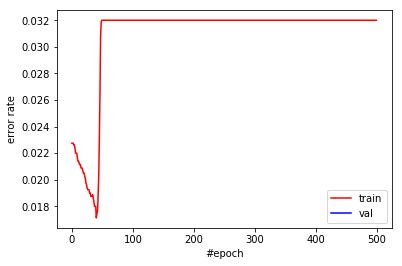

In [7]:
layers =[
    {'type':'linear','shape':(2,8)},
    {'type':'tanh'},
    {'type':'linear','shape':(8,8)},
    {'type':'tanh'},
    {'type':'linear','shape':(8,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    50.00,batch loss: 0.87
epoch: 0, batch:     2, batch_acc:    56.25,batch loss: 0.65
epoch: 0, batch:     3, batch_acc:    56.25,batch loss: 0.60
epoch: 0, batch:     4, batch_acc:    37.50,batch loss: 1.01
epoch: 0, batch:     5, batch_acc:    62.50,batch loss: 0.49
epoch: 0, batch:     6, batch_acc:    43.75,batch loss: 0.83
epoch: 0, batch:     7, batch_acc:    43.75,batch loss: 0.81
epoch: 0, batch:     8, batch_acc:    43.75,batch loss: 0.96
epoch: 0, batch:     9, batch_acc:    56.25,batch loss: 0.63
epoch: 0, batch:    10, batch_acc:    50.00,batch loss: 0.81
epoch: 0, batch:    11, batch_acc:    31.25,batch loss: 1.06
epoch: 0, batch:    12, batch_acc:    37.50,batch loss: 0.99
epoch: 0, batch:    13, batch_acc:    43.75,batch loss: 0.88
epoch: 0, batch:    14, batch_acc:    43.75,batch loss: 0.90
epoch: 0, batch:    15, batch_acc:    43.75,batch loss: 0.93
epoch: 0, batch:    16, batch_acc:    68.75,batch loss: 0.48
epoch: 0, batch:    17, 

 39%|███████████████████████████████████████████▎                                                                  | 197/500 [00:01<00:02, 110.53it/s]

epoch: 200, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 200, batch:     2, batch_acc:    12.50,batch loss: 1.75
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 200, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     5, batch_acc:    18.75,batch loss: 1.62
epoch: 200, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:     8, batch_acc:    25.00,batch loss: 1.50
epoch: 200, batch:     9, batch_acc:    37.50,batch loss: 1.25
epoch: 200, batch:    10, batch_acc:    50.00,batch loss: 1.00
epoch: 200, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    14, batch_acc:    25.00,batch loss: 1.50
epoch: 200, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 200, batch:    16, batch_acc:    31.25,batch los

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 396/500 [00:04<00:01, 80.21it/s]

epoch: 400, batch:     1, batch_acc:    43.75,batch loss: 1.12
epoch: 400, batch:     2, batch_acc:    12.50,batch loss: 1.75
epoch: 400, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:     4, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     5, batch_acc:    18.75,batch loss: 1.62
epoch: 400, batch:     6, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     7, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:     8, batch_acc:    25.00,batch loss: 1.50
epoch: 400, batch:     9, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:    10, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:    11, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    12, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    13, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    14, batch_acc:    25.00,batch loss: 1.50
epoch: 400, batch:    15, batch_acc:    31.25,batch loss: 1.37
epoch: 400, batch:    16, batch_acc:    31.25,batch los

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 84.74it/s]


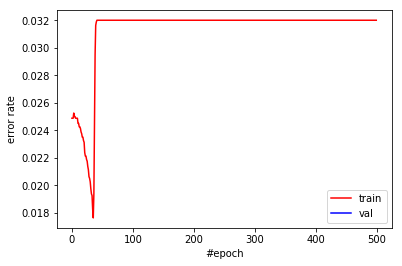

In [8]:
layers =[
    {'type':'linear','shape':(2,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


2.How do the learning/error curves for the training and the validation sets compare? Are they similar? In what cases do you observe more dissimilarity?

In [9]:
def generate_data_by_class():
    N=128
    mA=(1, 0.3) 
    mB=(0, 0.1) 
    sigmaA=0.2 
    sigmaB=0.3
    np.random.seed(100)
    cov = np.eye(2)
    classA1 = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,N//2)
    classA2 = np.random.multivariate_normal([-1,0.3],sigmaA*sigmaA*cov,N//2)
    A = np.concatenate((classA1,classA2))
    B = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,N)
    np.random.shuffle(A)
    np.random.shuffle(B)
    return A,B


def divide_data(option,A,B):
    N=128
    #random 25% from each class
    if option == 1:
        X_train = np.concatenate((A[:N*3//4],B[:N*3//4]))
        Y_train = np.concatenate((np.ones(N*3//4), -np.ones(N*3//4)))
        permute = np.random.permutation(X_train.shape[0])
        np.random.shuffle(permute)
        X_train = X_train[permute,:]
        Y_train = Y_train[permute]

        X_val = np.concatenate((A[N*3//4:],B[N*3//4:]))
        Y_val =  np.concatenate((np.ones(N//4), -np.ones(N//4)))
        permute = np.random.permutation(X_val.shape[0])
        np.random.shuffle(permute)
        X_val = X_val[permute,:]
        Y_val = Y_val[permute]

    #random 50% from classA
    if option == 2:
        X_train = np.concatenate((A[:N//2],B))
        Y_train = np.concatenate((np.ones(N//2), -np.ones(N)))
        permute = np.random.permutation(X_train.shape[0])
        np.random.shuffle(permute)
        X_train = X_train[permute,:]
        Y_train = Y_train[permute]

        X_val = A[N//2:]
        Y_val = -np.ones(N//2)
        permute = np.random.permutation(X_val.shape[0])
        np.random.shuffle(permute)
        X_val = X_val[permute,:]
        Y_val = Y_val[permute]

    #random 50% from classB
    if option == 3:
        X_train = np.concatenate((A,B[:N//2]))
        Y_train = np.concatenate((np.ones(N), -np.ones(N//2)))
        permute = np.random.permutation(X_train.shape[0])
        np.random.shuffle(permute)
        X_train = X_train[permute,:]
        Y_train = Y_train[permute]
        
        X_val = B[N//2:]
        Y_val = -np.ones(N//2)
        permute = np.random.permutation(X_val.shape[0])
        np.random.shuffle(permute)
        X_val = X_val[permute,:]
        Y_val = Y_val[permute]
    #20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0
    if option == 4:
        AL = np.where(A[:,0]<0)[0]
        AR = np.where(A[:,0]>0)[0]
        AL = AL[:len(AL)//5]
        AR = AR[:len(AR)*4//5]
        A_val_i = np.concatenate((AL,AR))
        A_train =np.array([ A[i,:]for i in range(A.shape[0]) if i not in A_val_i])
        A_val = A[A_val_i,:]
        X_train = np.concatenate((A_train,B))
        Y_train = np.concatenate((np.ones(A_train.shape[0]), -np.ones(B.shape[0])))
        permute = np.random.permutation(X_train.shape[0])
        np.random.shuffle(permute)
        X_train = X_train[permute,:]
        Y_train = Y_train[permute]

        X_val = A_val
        Y_val = np.ones(A_val.shape[0])
        permute = np.random.permutation(X_val.shape[0])
        np.random.shuffle(permute)
        X_val = X_val[permute,:]
        Y_val = Y_val[permute]

    return (X_train,Y_train),(X_val,Y_val)



  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    37.50,batch loss: 0.73
epoch: 0, batch:     2, batch_acc:    56.25,batch loss: 0.56
epoch: 0, batch:     3, batch_acc:    31.25,batch loss: 0.92
epoch: 0, batch:     4, batch_acc:    68.75,batch loss: 0.43
epoch: 0, batch:     5, batch_acc:    37.50,batch loss: 0.74
epoch: 0, batch:     6, batch_acc:    37.50,batch loss: 0.81
epoch: 0, batch:     7, batch_acc:    56.25,batch loss: 0.61
epoch: 0, batch:     8, batch_acc:    50.00,batch loss: 0.65
epoch: 0, batch:     9, batch_acc:    43.75,batch loss: 0.75
epoch: 0, batch:    10, batch_acc:    68.75,batch loss: 0.47
epoch: 0, batch:    11, batch_acc:    56.25,batch loss: 0.56
epoch: 0, batch:    12, batch_acc:    25.00,batch loss: 0.72


 37%|████████████████████████████████████████▉                                                                     | 186/500 [00:01<00:02, 150.47it/s]

epoch: 200, batch:     1, batch_acc:    56.25,batch loss: 0.87
epoch: 200, batch:     2, batch_acc:    50.00,batch loss: 1.00
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 200, batch:     4, batch_acc:    56.25,batch loss: 0.87
epoch: 200, batch:     5, batch_acc:    50.00,batch loss: 1.00
epoch: 200, batch:     6, batch_acc:    50.00,batch loss: 1.00
epoch: 200, batch:     7, batch_acc:    50.00,batch loss: 1.00
epoch: 200, batch:     8, batch_acc:    56.25,batch loss: 0.87
epoch: 200, batch:     9, batch_acc:    56.25,batch loss: 0.87
epoch: 200, batch:    10, batch_acc:    37.50,batch loss: 1.25
epoch: 200, batch:    11, batch_acc:    62.50,batch loss: 0.75
epoch: 200, batch:    12, batch_acc:    37.50,batch loss: 1.25


 79%|██████████████████████████████████████████████████████████████████████████████████████▍                       | 393/500 [00:02<00:00, 159.97it/s]

epoch: 400, batch:     1, batch_acc:    56.25,batch loss: 0.87
epoch: 400, batch:     2, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:     3, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:     4, batch_acc:    56.25,batch loss: 0.87
epoch: 400, batch:     5, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:     6, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:     7, batch_acc:    50.00,batch loss: 1.00
epoch: 400, batch:     8, batch_acc:    56.25,batch loss: 0.87
epoch: 400, batch:     9, batch_acc:    56.25,batch loss: 0.87
epoch: 400, batch:    10, batch_acc:    37.50,batch loss: 1.25
epoch: 400, batch:    11, batch_acc:    62.50,batch loss: 0.75
epoch: 400, batch:    12, batch_acc:    37.50,batch loss: 1.25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 150.94it/s]


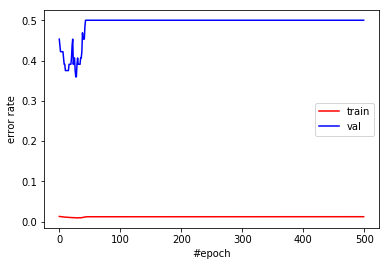

In [10]:
A,B = generate_data_by_class()
(X_train,Y_train),(X_val,Y_val) = divide_data(1,A,B)
layers =[
    {'type':'linear','shape':(2,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X_train,Y_train,opt,val=(X_val,Y_val))

3.How do these curves and the network performance depend on the size of the hidden layer in various training/validation data configurations (the aforementioned subsampling options)

In [ ]:
node = [1,2,4,6,8,10]
option = [1,2,3,4]
dic = ['random 25% from each class','• random 50% from classA' , '• random 50% from classB',
'• 20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0']
for i in option:
    for j in node:
        (X_train,Y_train),(X_val,Y_val) = divide_data(i,A,B)
        layers =[
            {'type':'linear','shape':(2,j)},
            {'type':'tanh'},
            {'type':'linear','shape':(j,j)},
            {'type':'tanh'},
            {'type':'linear','shape':(j,1)},
            {'type':'tanh'}
        ]
        print(dic[i-1],"\nlayer size %d"%j)
        net = Net(layers)
        opt = SGD(net.parameters,lr=1e-3)
        net.train(X_train,Y_train,opt,val=(X_val,Y_val))

random 25% from each class 
layer size 1


  0%|                                                                                                                         | 0/500 [00:00<?, ?it/s]

epoch: 0, batch:     1, batch_acc:    50.00,batch loss: 0.59
epoch: 0, batch:     2, batch_acc:    68.75,batch loss: 0.42
epoch: 0, batch:     3, batch_acc:    56.25,batch loss: 0.58
epoch: 0, batch:     4, batch_acc:    50.00,batch loss: 0.58
epoch: 0, batch:     5, batch_acc:    56.25,batch loss: 0.51
epoch: 0, batch:     6, batch_acc:    68.75,batch loss: 0.52
epoch: 0, batch:     7, batch_acc:    43.75,batch loss: 0.60
epoch: 0, batch:     8, batch_acc:    56.25,batch loss: 0.50
epoch: 0, batch:     9, batch_acc:    50.00,batch loss: 0.56
epoch: 0, batch:    10, batch_acc:    68.75,batch loss: 0.48
epoch: 0, batch:    11, batch_acc:    56.25,batch loss: 0.55
epoch: 0, batch:    12, batch_acc:    37.50,batch loss: 0.67


 38%|██████████████████████████████████████████                                                                    | 191/500 [00:01<00:01, 191.23it/s]

epoch: 200, batch:     1, batch_acc:    43.75,batch loss: 1.07
epoch: 200, batch:     2, batch_acc:    43.75,batch loss: 1.07
epoch: 200, batch:     3, batch_acc:    37.50,batch loss: 1.19
epoch: 200, batch:     4, batch_acc:    50.00,batch loss: 0.95
epoch: 200, batch:     5, batch_acc:    68.75,batch loss: 0.59
epoch: 200, batch:     6, batch_acc:    43.75,batch loss: 1.07
epoch: 200, batch:     7, batch_acc:    56.25,batch loss: 0.83
epoch: 200, batch:     8, batch_acc:    37.50,batch loss: 1.19
epoch: 200, batch:     9, batch_acc:    68.75,batch loss: 0.59
epoch: 200, batch:    10, batch_acc:    75.00,batch loss: 0.48
epoch: 200, batch:    11, batch_acc:    37.50,batch loss: 1.19
epoch: 200, batch:    12, batch_acc:    37.50,batch loss: 1.19


 70%|█████████████████████████████████████████████████████████████████████████████▏                                | 351/500 [00:01<00:00, 194.21it/s]

4.Is there any difference between a batch and sequential learning approach in terms of the validation performance?

In [ ]:
(X_train,Y_train),(X_val,Y_val) = divide_data(1,A,B)
print("sequential")
layers =[
    {'type':'linear','shape':(2,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X_train,Y_train,opt,val=(X_val,Y_val),batch_size=1)
print("batch")
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X_train,Y_train,opt,val=(X_val,Y_val))





5.Make an attempt at approximating the resulting decision boundary, i.e. where the network output is 0 (between the target labels of -1 and 1 for two classes, respectively).

In [ ]:
from mlxtend.plotting import plot_decision_regions
X,Y = generate_data()
for i, it in enumerate(X):
    if Y[i] == -1:
        plt.plot(X[i][0], X[i][1], 'r.')
    else:
        plt.plot(X[i][0], X[i][1], 'b.')
plt.show()
layers =[
    {'type':'linear','shape':(2,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,16)},
    {'type':'tanh'},
    {'type':'linear','shape':(16,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)
for i, it in enumerate(X):
    if Y[i] == -1:
        plt.plot(X[i][0], X[i][1], 'r.')
    else:
        plt.plot(X[i][0], X[i][1], 'b.')
xgrid = np.linspace(-2, 2, 100)
ygrid = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(xgrid, ygrid)
Z = np.array([[np.sign(net.predict(np.array([x, y]))) for x in xgrid] for y in ygrid]).reshape(100,100)
plt.contour(X, Y, Z, levels=(-1, 0, 1), colors=('red', 'black', 'blue'), linewidths=(1, 1, 1))
plt.show()

##The encoder problem

In [ ]:
X = np.zeros((8,8))-1+np.identity(8)*2
Y = X

In [ ]:
layers =[
    {'type':'linear','shape':(8,3)},
    {'type':'tanh'},
    {'type':'linear','shape':(3,8)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt,batch_size=1)


In [ ]:
r=net.layers[0].forward(X)
r=net.layers[1].forward(r)
print(r)
print("Weight")
print(net.layers[0].W.data)

In [ ]:
layers =[
    {'type':'linear','shape':(8,2)},
    {'type':'tanh'},
    {'type':'linear','shape':(2,8)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt,batch_size=1)
